In [2]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Create vanilla results dataframe from the provided data
testset_name = "finals_serial"

results_interpretor = rri.RayResultsinterpreter()

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

# Define color scheme, line styles and markers
color_scheme = {
    128: "#1f77b4",    # Blue
    1024: "#2ca02c",   # Green  
    8192: "#ff7f0e",   # Orange
}

marker_scheme = {
    128: "o",          # Circle
    1024: "v",         # Down triangle
    8192: "s",         # Square
}

linestyle_scheme = {
    "Vanilla NN": "-",  # Dashed
    "GNN": "--",  # Dash-dot
}

# Define paths for each architecture
# Define architectures with their path patterns
architectures = {
    "Vanilla NN": lambda config: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_serial',
    "echelon_stock_hard": lambda config: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/echelon_stock_hard',
    "GNN": lambda config: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_selfloop',
}

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

# Define configs and sample sizes
configs = ["serial_system_3", "serial_system_4", "serial_system_5", "serial_system_6", "serial_system_7"]
sample_sizes = [128, 1024, 8192]

dfs = []

# Create dataframes for each architecture, config and sample size
for arch_name, path_fn in architectures.items():
    for config in configs:
        path = path_fn(config)
        # Extract system length from config name (e.g., "serial_system_3" -> 3)
        system_length = int(config.split('_')[-1])
        
        for sample_size in sample_sizes:
            df = results_interpretor.make_table({1: path},
                {'train_dev_sample_and_batch_size': [sample_size],
                 'store_underage_cost': [9],
                 'store_lead_time': [4],
                 'samples': [1],
                 'config': [config]},
                default_condition_setter, custom_data_filler,
                sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by, test_loss_limit=25)
            if df.empty:
                continue
            
            df.insert(2, 'Architecture Class', arch_name)
            df.insert(1, 'hyperparam_name', arch_name)
            df['train_dev_sample_and_batch_size'] = sample_size
            df['config'] = config
            df['system_length'] = system_length
            dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)

In [6]:
import numpy as np

test_loss_column = 'Test Loss'

test_losses = []
for _, row in df.iterrows():
    test_loss_path = str(row['path']) +"/"+ row['config'] + "_5000_test_loss.txt"
    try:
        with open(test_loss_path, 'r') as f:
            value = float(f.read().strip())
    except Exception:
        value = np.nan
    test_losses.append(value)

df[test_loss_column] = test_losses

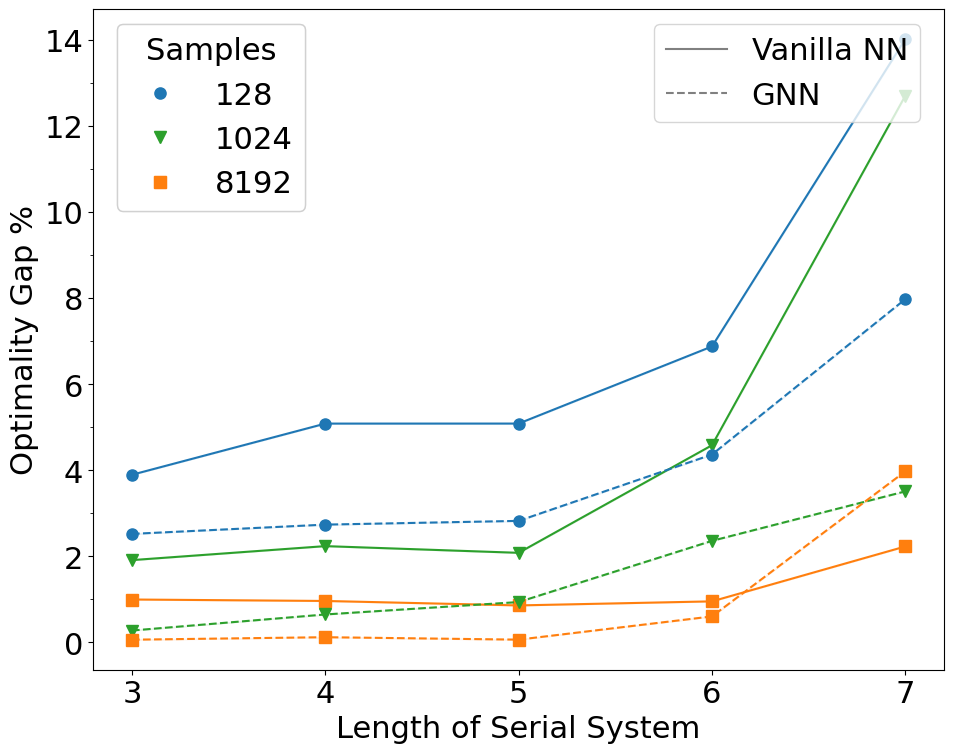

In [7]:

# Get optimal losses from echelon_stock_hard with 8K samples
optimal_losses = {}
for config in configs:
    system_length = int(config.split('_')[-1])
    optimal_data = df[(df['Architecture Class'] == 'echelon_stock_hard') & 
                      (df['train_dev_sample_and_batch_size'] == 8192) & 
                      (df['config'] == config)]
    if not optimal_data.empty:
        optimal_losses[system_length] = optimal_data['Test Loss'].min()

# Calculate optimality gap percentage using echelon_stock_hard policy's test losses with 8K samples
stats_by_arch_sample_and_system_length = {}
for system_length, optimal_loss in optimal_losses.items():
    system_data = df[df['system_length'] == system_length].copy()
    
    # Skip echelon_stock_hard policy in the plot
    system_data = system_data[system_data['Architecture Class'] != 'echelon_stock_hard']
    
    if system_data.empty:
        continue
        
    system_data.loc[:, 'Gap %'] = ((system_data['Test Loss'] - optimal_loss) / optimal_loss) * 100
    
    for arch in system_data['Architecture Class'].unique():
        for sample_size in sample_sizes:
            key = (arch, sample_size)
            if key not in stats_by_arch_sample_and_system_length:
                stats_by_arch_sample_and_system_length[key] = []
                
            sample_data = system_data[(system_data['train_dev_sample_and_batch_size'] == sample_size) & 
                                   (system_data['Architecture Class'] == arch)]
            if not sample_data.empty:
                gaps = sample_data['Gap %'].to_numpy()
                mean_gap = np.mean(gaps)
                std_gap = np.std(gaps)
                ci_95 = 1.96 * std_gap / np.sqrt(len(gaps))
                stats_by_arch_sample_and_system_length[key].append({
                    'system_length': system_length,
                    'mean_gap': mean_gap,
                    'ci_lower': mean_gap - ci_95,
                    'ci_upper': mean_gap + ci_95
                })

# Create plot
FONTSIZE = 22
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': FONTSIZE})

# Plot lines
for (arch, sample_size), stats in stats_by_arch_sample_and_system_length.items():
    stats_df = pd.DataFrame(stats)
    if not stats_df.empty:
        # Convert pandas series to numpy arrays before plotting
        system_length_array = stats_df['system_length'].to_numpy()
        mean_gap_array = stats_df['mean_gap'].to_numpy()
        ci_lower_array = stats_df['ci_lower'].to_numpy()
        ci_upper_array = stats_df['ci_upper'].to_numpy()
        
        plt.plot(system_length_array, mean_gap_array,
                marker=marker_scheme[sample_size],
                color=color_scheme[sample_size],
                linestyle=linestyle_scheme[arch],
                markersize=8)
        
        plt.fill_between(system_length_array,
                        ci_lower_array,
                        ci_upper_array,
                        color=color_scheme[sample_size],
                        alpha=0.1)

# Create separate legend entries for architectures and sample sizes
arch_lines = [plt.Line2D([0], [0], color='gray', linestyle=linestyle_scheme[arch], label=arch) 
              for arch in linestyle_scheme.keys()]
sample_patches = [plt.Line2D([0], [0], color=color_scheme[size], marker=marker_scheme[size], 
                            linestyle='none', label=f'{size}', markersize=8)
                 for size in color_scheme.keys()]

plt.xlabel('Length of Serial System', fontsize=FONTSIZE)
plt.ylabel('Optimality Gap %', fontsize=FONTSIZE)
# plt.grid(True)
plt.xticks(range(3, 8), fontsize=FONTSIZE)  # Show 3 to 7 length
plt.yticks(fontsize=FONTSIZE)

# Add minor y ticks at intervals of 1
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(1))

# Create two separate legends
# Right legend for architectures
legend1 = plt.legend(handles=arch_lines, 
                    bbox_to_anchor=(0.99, 1),
                    loc='upper right', 
                    fontsize=FONTSIZE)
plt.gca().add_artist(legend1)

# Left legend for sample sizes with title
legend2 = plt.legend(handles=sample_patches,
                    title='Samples',
                    bbox_to_anchor=(0.01, 1),
                    loc='upper left',
                    fontsize=FONTSIZE)
plt.gca().add_artist(legend2)
legend2.get_title().set_fontsize(FONTSIZE)


plt.tight_layout()
plt.show()

In [9]:
print(df.to_string())

    # of stores     hyperparam_name  train_dev_sample_and_batch_size  Architecture Class  store_underage_cost  store_lead_time  samples           config  Learning Rate  Train Loss   Dev Loss  Test Loss  # of runs                                                                                                                                                                                                                                              path  system_length
0             1          Vanilla NN                              128          Vanilla NN                    9                4        1  serial_system_3         0.0100   10.016856  10.130602  10.250312         25      /user/ml4723/Prj/NIC/ray_results/finals_serial/vanilla_serial/run_2025-05-08_16-36-30/run_1f4d9_00390_390_config=serial_system_3,dev_ignore_periods=60,dev_periods=100,different_for_each_sample=True,early_stop_check_e_2025-05-09_06-21-10              3
1             1          Vanilla NN                         

In [4]:
mode = "test"

gpus = [1, 2, 5, 7]

def run_main_run(model_path, setting_name, gpu_idx):
    try:
        # Extract hyperparam name from model path
        hyperparam_name = model_path.split('/')[7]
        print(f"Running main_run.py for path {model_path}")
        cmd = [
            "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
            "main_run.py",
            mode, # test or test_on_dev
            setting_name,
            hyperparam_name,
            str(model_path),
            str(gpus[gpu_idx])
        ]
        env = {
            **os.environ,
            "MKL_THREADING_LAYER": "GNU",
            "MKL_SERVICE_FORCE_INTEL": "1"
        }
        subprocess.run(cmd, capture_output=True, text=True, check=True, env=env, cwd="/user/ml4723/Prj/NIC/")
    except subprocess.CalledProcessError as e:
        print(f"Error running main_run.py for path {model_path}: {e}")
        print(f"Error output: {e.stderr}")
    except Exception as e:
        print(f"Unexpected error running main_run.py for path {model_path}: {e}")

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    gpu_idx = 0
    for _, row in df.iterrows():
        path = str(row['path']) + '/model.pt'
        while len(futures) >= 4*len(gpus):
            done, not_done = concurrent.futures.wait(
                futures, 
                return_when=concurrent.futures.FIRST_COMPLETED
            )
            futures = list(not_done)
        futures.append(executor.submit(run_main_run, path, row['config'] + '_5000', gpu_idx))
        gpu_idx = (gpu_idx + 1) % len(gpus)
    concurrent.futures.wait(futures)


Running main_run.py for path /user/ml4723/Prj/NIC/ray_results/finals_serial/vanilla_serial/run_2025-05-08_16-36-30/run_1f4d9_00390_390_config=serial_system_3,dev_ignore_periods=60,dev_periods=100,different_for_each_sample=True,early_stop_check_e_2025-05-09_06-21-10/model.pt
Running main_run.py for path /user/ml4723/Prj/NIC/ray_results/finals_serial/vanilla_serial/run_2025-05-08_16-36-30/run_1f4d9_00195_195_config=serial_system_3,dev_ignore_periods=60,dev_periods=100,different_for_each_sample=True,early_stop_check_e_2025-05-08_16-36-33/model.pt
Running main_run.py for path /user/ml4723/Prj/NIC/ray_results/finals_serial/vanilla_serial/run_2025-05-08_16-36-30/run_1f4d9_00000_0_config=serial_system_3,dev_ignore_periods=60,dev_periods=100,different_for_each_sample=True,early_stop_check_epo_2025-05-08_16-36-31/model.pt
Running main_run.py for path /user/ml4723/Prj/NIC/ray_results/finals_serial/vanilla_serial/run_2025-05-08_16-36-30/run_1f4d9_00361_361_config=serial_system_4,dev_ignore_period